# Fitting an SNN to do a Classification Task

In the example below, we will use gradient descent to fit the parameters of an
SNN. Since Jaxley implements surrogate gradients for Fire channels by default,
we can backpropagate through the entire network, despite the SNN implementing
non-differentiable functions.


In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import config
import matplotlib.pyplot as plt
from tqdm import tqdm

import jaxley as jx
from jaxley.channels import Fire, Leak
from jaxley.synapses import SpikeSynapse

# Set up configuration
config.update("jax_enable_x64", True)

dt = 1e-3
T = 0.20
time_array = jnp.arange(0.0, T, dt)

reset_voltage = 0.0
tau_mem = 10e-3
params_init = {
    "Leak_gLeak": jnp.array(tau_mem),
    "Leak_eLeak": jnp.array(reset_voltage),
    "Fire_vth": jnp.array(1.0),
    "Fire_vreset": jnp.array(reset_voltage),
}

## Neuron factory helpers

We create a small helper function `get_neuron` that instantiates a `jx.Compartment`,
inserts the Leak (and optionally Fire) channels, sets parameters, and marks
parameters as trainable when requested. `get_neurons` simply creates a list of
neurons for a layer.

In [2]:
def get_neuron(
    params: dict[str, float],
    set_params: bool = True,
    trainable: bool = False,
    fires: bool = True,
) -> jx.Compartment:
    # create a compartment and cell
    comp = jx.Compartment()

    # insert the channels
    comp.insert(Leak())
    if fires:
        comp.insert(Fire())

    # set the initial parameter4
    if set_params:
        for param in params.keys():
            if fires or "Fire" not in param:
                comp.set(param, params[param])

    if trainable:
        for param in params.keys():
            if fires or "Fire" not in param:
                comp.make_trainable(param)

    # Make sure to make the neurons unitless
    comp.set("length", 1.0 / (2 * jnp.pi * 1e-5))
    comp.set("radius", 1.0)  # 1.0 is also the default.
    comp.set("v", 0.0)

    return comp


def get_neurons(
    params: dict[str, float], num: int, trainable: bool = False, fires: bool = True
) -> list[jx.Compartment]:
    return [get_neuron(params, trainable=trainable, fires=fires) for _ in range(num)]


def normal(subkey, mean, std, shape):
    return mean + (jax.random.normal(subkey, shape) * std)

## Simulation and network hyperparameters

Set RNG seed, sizes of each layer, and build the network (input → hidden → output).
Note that the output neurons are created with `fires=False` because we will read
their membrane potentials rather than their spikes for classification.

In [3]:
# Set seed and layer sizes
seed = 1701
key = jax.random.key(seed)
batch_size = 256
n_input = 100
n_hidden = 4
n_output = 2

# Create network
input_neurons = get_neurons(params_init, n_input)
hidden_neurons = get_neurons(params_init, n_hidden)
output_neurons = get_neurons(params_init, n_output, fires=False)
net = jx.Network(input_neurons + hidden_neurons + output_neurons)

# index ranges of layers in network
hidden_end = n_input + n_hidden
output_end = hidden_end + n_output
input_range = range(n_input)
hidden_range = range(n_input, hidden_end)
output_range = range(hidden_end, output_end)

# connect neurons
jx.fully_connect(net.cell(input_range), net.cell(hidden_range), SpikeSynapse())
jx.fully_connect(net.cell(hidden_range), net.cell(output_range), SpikeSynapse())

tau_syn = 5e-3
alpha = float(jnp.exp(-dt / tau_syn))
beta = float(jnp.exp(-dt / tau_mem))
weight_scale = 7 * (1.0 - beta)  # this should give us some spikes to begin with

# Set random synaptic weights
parameters = None
total_edges = n_input * n_hidden + n_hidden * n_output
l1_edges = n_input * n_hidden
l2_edges = n_hidden * n_output
key, subkey = jax.random.split(key)
gs_l1 = normal(subkey, 0.0, 10.0, (l1_edges))
gs_l1 = [{"SpikeSynapse_gS": gs_l1}]
key, subkey = jax.random.split(key)
gs_l2 = normal(subkey, 0.0, 10.0, (l2_edges))
gs_l2 = [{"SpikeSynapse_gS": gs_l2}]

for edge in range(l1_edges):
    net.select(edges=edge).set("SpikeSynapse_gS", gs_l1[0]["SpikeSynapse_gS"][edge])

for edge in range(l2_edges):
    net.select(edges=(l1_edges + edge)).set(
        "SpikeSynapse_gS", gs_l2[0]["SpikeSynapse_gS"][edge]
    )

net.select(edges="all").make_trainable("SpikeSynapse_gS")

parameters = net.get_parameters()

Number of newly added trainable parameters: 408. Total number of trainable parameters: 408


## Creating input currents / dataset

For this toy classification task we sample Poisson spike trains for the inputs
and convolve them with a small kernel (`i_min`) to create continuous input currents.
We then pack `batch_size` such examples into `current_batches` which will be used
for training.

In [4]:
i_min = jnp.array([508.0] * 2)
freq = 5  # Hz
prob = freq * dt
key, subkey = jax.random.split(key)
mask = jax.random.uniform(subkey, (batch_size, n_input, int(T / dt)))
x_data = jnp.where(mask < prob, 1.0, 0.0)

current_batches = jnp.array(
    [
        [jnp.convolve(i_min, x_data[i][j], "same") for j in range(n_input)]
        for i in range(batch_size)
    ]
)

net.delete_recordings()
net.cell(output_range).record("v")

Added 2 recordings. See `.recordings` for details.


## Simulation helpers

`simulate_network` runs a single simulation and returns the voltage traces
of the output neurons. We JIT-compile and vectorize over batches with
`simulate_network_batches` so training is faster.

In [5]:
def simulate_network(params, current):
    """Simulates the network, returning the voltage traces of the output neurons"""
    data_stimuli = net.cell(range(n_input)).data_stimulate(current, None)
    return jx.integrate(
        net,
        data_stimuli=data_stimuli,
        params=params,
        delta_t=dt,
        t_max=T,
    )


simulate_network_batches = jax.jit(jax.vmap(simulate_network, in_axes=(None, 0)))

## Loss and accuracy

We compute the maximum membrane potential across time for each output neuron
and apply a softmax to those maxima to obtain class log-probabilities. The loss
is the standard cross-entropy between the predicted log-probabilities and
one-hot targets. The `get_accuracy` helper computes a simple classification
accuracy using `argmax` of the maxima.

In [6]:
def cross_entropy(logprobs, targets):
    target_class = targets
    nll = jnp.take_along_axis(logprobs, jnp.expand_dims(target_class, axis=1), axis=1)
    ce = -jnp.mean(nll)
    return ce


def loss_fn(params, targets):
    voltages = simulate_network_batches(params, current_batches)
    maximums = jnp.max(voltages, axis=2)
    log_p_y = jax.nn.log_softmax(maximums, axis=1)
    return cross_entropy(log_p_y, targets)


key, subkey = jax.random.split(key)
targets = jnp.where(
    jax.random.uniform(subkey, (batch_size), minval=0.0, maxval=1.0) < 0.5, 1, 0
)


def get_accuracy(params):
    voltages = simulate_network_batches(params, current_batches)
    maximums = jnp.max(voltages, axis=2)
    am = jnp.argmax(maximums, axis=1)  # argmax over output units
    acc = jnp.mean((targets == am))  # compare to labels
    return acc

## Optimization and training

We use `optax.adam` to optimize the synaptic weights (which we flagged as
trainable earlier). The training loop JIT-compiles the gradient computation and
updates the parameters on each epoch. We also display a progress bar using
`tqdm` with the current loss and accuracy.

In [7]:
grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
optimizer = optax.adam(learning_rate=0.1)
opt_params = parameters
opt_state = optimizer.init(opt_params)

n_epochs = 500
with tqdm(total=n_epochs, desc="Training") as pbar:
    for epoch in range(n_epochs):
        loss, gradient = grad_fn(opt_params, targets)

        # Optimizer step.
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        pbar.set_postfix(
            {"Loss": f"{loss:.4f}", "Accuracy": f"{get_accuracy(opt_params):.3f}"}
        )
        pbar.update()

Training: 100%|██████████████████████████████████████| 500/500 [08:09<00:00,  1.02it/s, Loss=0.2618, Accuracy=0.883]


## Visualizing output voltages

Finally, we run a simulation with the learned parameters and plot the output
membrane potentials across time. Since output neurons don't fire in this
example (they were created with `fires=False`), we inspect their voltages
directly to decide the predicted class. The predicted class is determined by the neuron's maximum voltage.

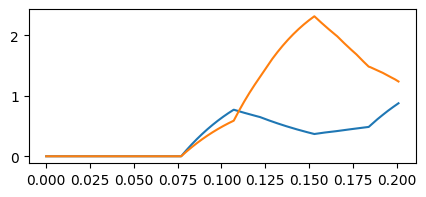

In [8]:
v = simulate_network(opt_params, current_batches[0])

time_vec = jnp.arange(0, T + 2 * dt, dt)
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = plt.plot(time_vec, v.T)
plt.show()